In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
train_data = MNIST('.', train = True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = MNIST('.', train = False, transform = torchvision.transforms.ToTensor(), download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 226kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.00MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.26MB/s]


In [3]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=256,
    shuffle=True,
    num_workers=6
)

test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=256,
    shuffle=False,
    num_workers=6
)

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

Text(0.5, 1.0, 'Image label: 2')

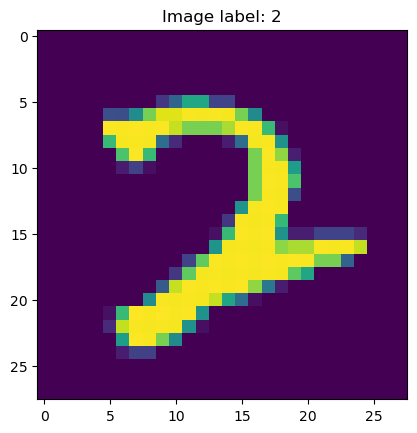

In [6]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')

In [11]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features, bias=False),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=num_classes)
        )
        
    def forward(self, x):
        return self.model(x)
    

In [12]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10

model = MLP(IMG_SIZE ** 2, HIDDEN_SIZE, NUM_CLASSES).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

In [15]:
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784).to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model(x).to(device)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')

Everything seems fine!


In [21]:
from tqdm.notebook import tqdm

for epoch in range(NUM_EPOCHS):
    for image, label in tqdm(train_data_loader):
        
        images = image.to(device)
        labels = label.to(device)
        
        optimizer.zero_grad()

        logits = model(torch.flatten(images, start_dim=1))
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

In [23]:
predicted_labels = []
real_labels = []
model.eval()
model.to(device)

with torch.no_grad():
    for batch in train_data_loader:
        inputs = batch[0].to(device)
        targets = batch[1].to(device)

        y_predicted = model(inputs.reshape(-1, 784)).to(device)

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(targets)

predicted_labels = torch.cat(predicted_labels).cpu()
real_labels = torch.cat(real_labels).cpu()

train_acc = (predicted_labels == real_labels).float().mean()

In [24]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.97372


In [27]:
predicted_labels = []
real_labels = []
model.eval()
model.to(device)

with torch.no_grad():
    for batch in test_data_loader:
        inputs = batch[0].to(device)
        targets = batch[1].to(device)

        y_predicted = model(inputs.reshape(-1, 784)).to(device)

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(targets)

predicted_labels = torch.cat(predicted_labels).cpu()
real_labels = torch.cat(real_labels).cpu()

test_acc = (predicted_labels == real_labels).float().mean()

In [28]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9679


In [29]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

In [38]:
import os
import json
assert os.path.exists('hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    predicted_labels = []
    model.eval()
    model.to(device)
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            inputs = eval_data[idx:idx+step].reshape(-1, 784).to(device)

            y_predicted = model(inputs)

            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels).numpy()
    return ','.join(map(str, predicted_labels.tolist()))

loaded_data_dict = np.load('hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train']).to(device)),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']).to(device))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved successfully')

File saved successfully
